In [2]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Handling Imbalance
from imblearn.over_sampling import SMOTE

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load Dataset
df = pd.read_csv("train_dataset_final1.csv")

# Shape and Sample
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (25247, 27)


,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [4]:
print(df.columns.tolist())


['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default']


In [5]:
# Check for nulls
print(df.isnull().sum())

# Check dtypes
df.dtypes

# Convert categorical if needed (e.g., sex, marriage)
categorical_cols = ['sex', 'marriage', 'education']
for col in categorical_cols:
    df[col] = df[col].astype('category')


Customer_ID             0
marriage                0
sex                     0
education               0
LIMIT_BAL               0
age                   126
pay_0                   0
pay_2                   0
pay_3                   0
pay_4                   0
pay_5                   0
pay_6                   0
Bill_amt1               0
Bill_amt2               0
Bill_amt3               0
Bill_amt4               0
Bill_amt5               0
Bill_amt6               0
pay_amt1                0
pay_amt2                0
pay_amt3                0
pay_amt4                0
pay_amt5                0
pay_amt6                0
AVG_Bill_amt            0
PAY_TO_BILL_ratio       0
next_month_default      0
dtype: int64


In [6]:
# Check how many NaNs exist per column
missing_summary = df.isnull().sum()
missing_summary[missing_summary > 0]


,0
age,126


In [7]:
# Separate column types
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include='category').columns.tolist()

# Impute numerical columns with median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Impute categorical columns with mode
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


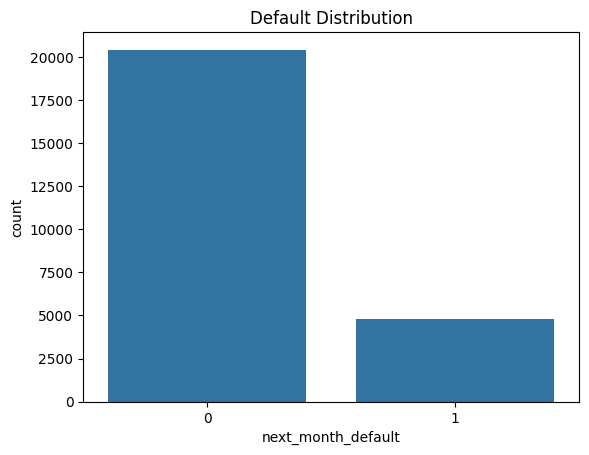

Default Rate: 19.04%


In [8]:
sns.countplot(data=df, x='next_month_default')
plt.title("Default Distribution")
plt.show()

default_rate = df['next_month_default'].mean()
print(f"Default Rate: {default_rate:.2%}")


- Around **19%** of customers defaulted on their payments in the next month.
- This indicates a **class imbalance**, with significantly more non-default cases.

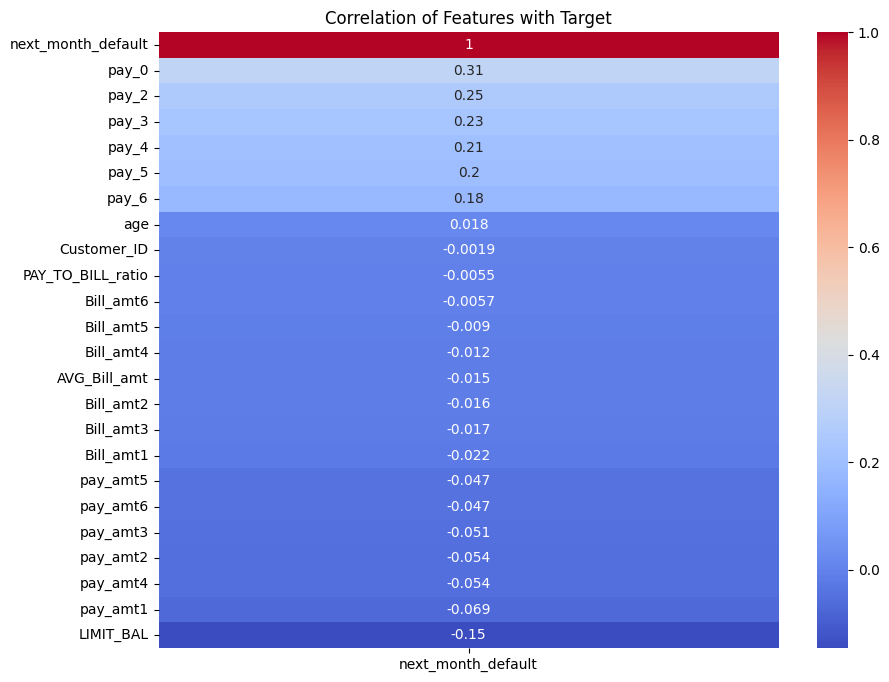

In [10]:
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['next_month_default']].sort_values(by='next_month_default', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Target")
plt.show()


A correlation heatmap showing how each numerical feature correlates with `next_month_default`. Helps identify predictive variables for modeling.

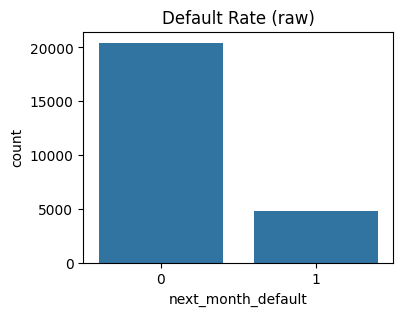

In [11]:
#  Distribution of target
plt.figure(figsize = (4,3))
sns.countplot(x='next_month_default', data=df)
plt.title("Default Rate (raw)")
plt.show()

Text(0.5, 1.0, 'PAY_TO_BILL Ratio by Default')

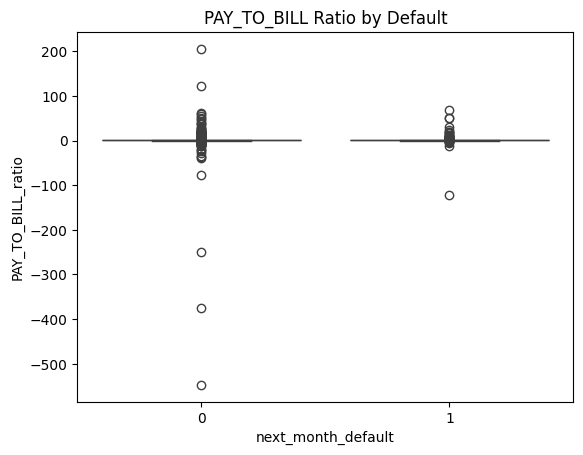

In [12]:
# PAY_TO_BILL_ratio
sns.boxplot(data=df, x='next_month_default', y='PAY_TO_BILL_ratio')
plt.title("PAY_TO_BILL Ratio by Default")


- Defaulters show **lower PAY_TO_BILL ratios**, meaning they pay a smaller proportion of their total billed amount.
- High number of **outliers on the low-payment side** for defaulters.

Text(0.5, 1.0, 'Age Distribution by Default Status')

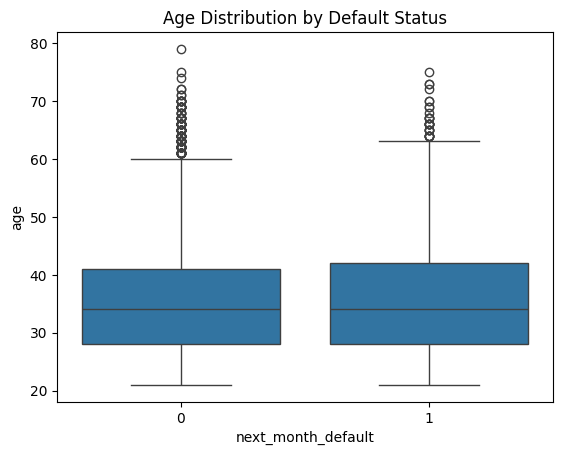

In [13]:
# Age vs Default
sns.boxplot(data=df, x='next_month_default', y='age')
plt.title("Age Distribution by Default Status")

- Age distribution is generally similar, but **slightly younger customers** are more prone to default.
- **Older individuals** tend to have better repayment behavior.

Text(0.5, 1.0, 'Credit Limit Distribution by Default Status')

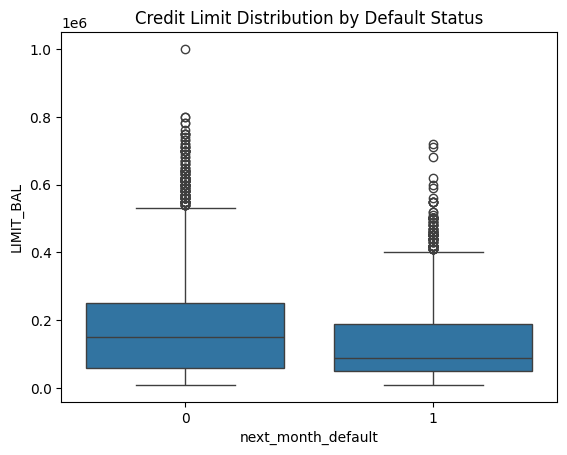

In [14]:
# LIMIT_BAL vs Default
sns.boxplot(data=df, x='next_month_default', y='LIMIT_BAL')
plt.title("Credit Limit Distribution by Default Status")

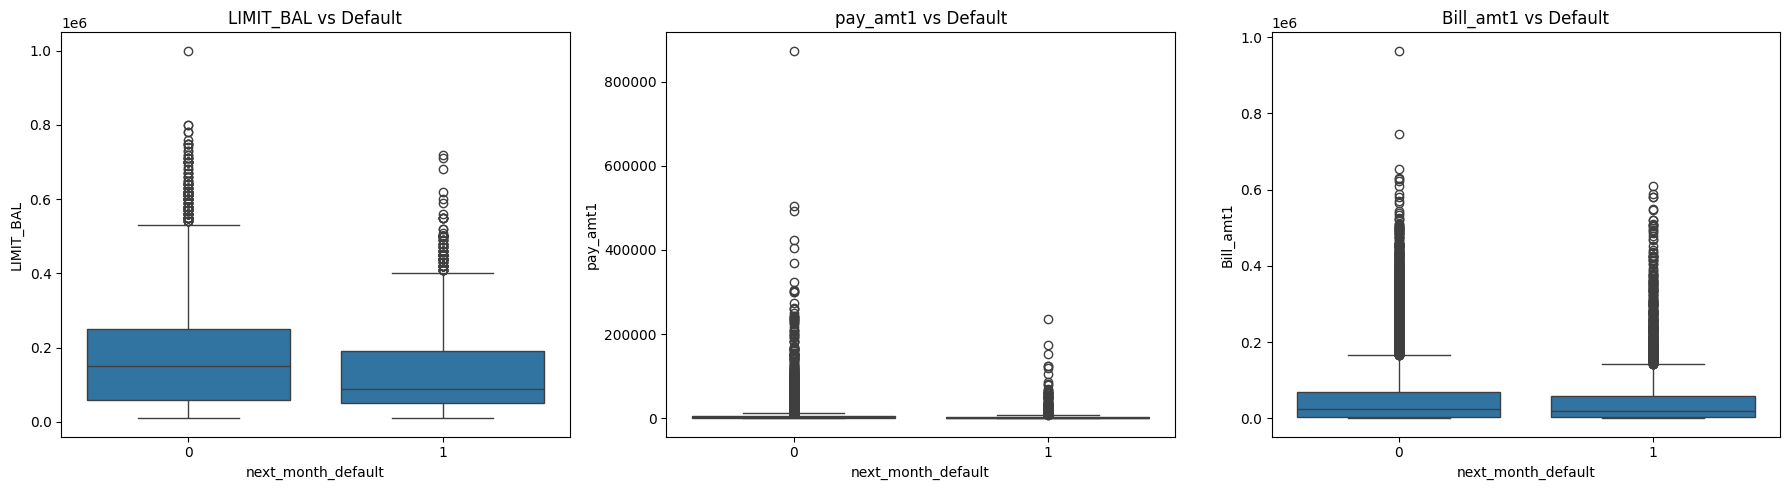

In [15]:
num_cols = ['LIMIT_BAL', 'pay_amt1', 'Bill_amt1']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i, col in enumerate(num_cols):
    sns.boxplot(x='next_month_default', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Default')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Feature Correlation')

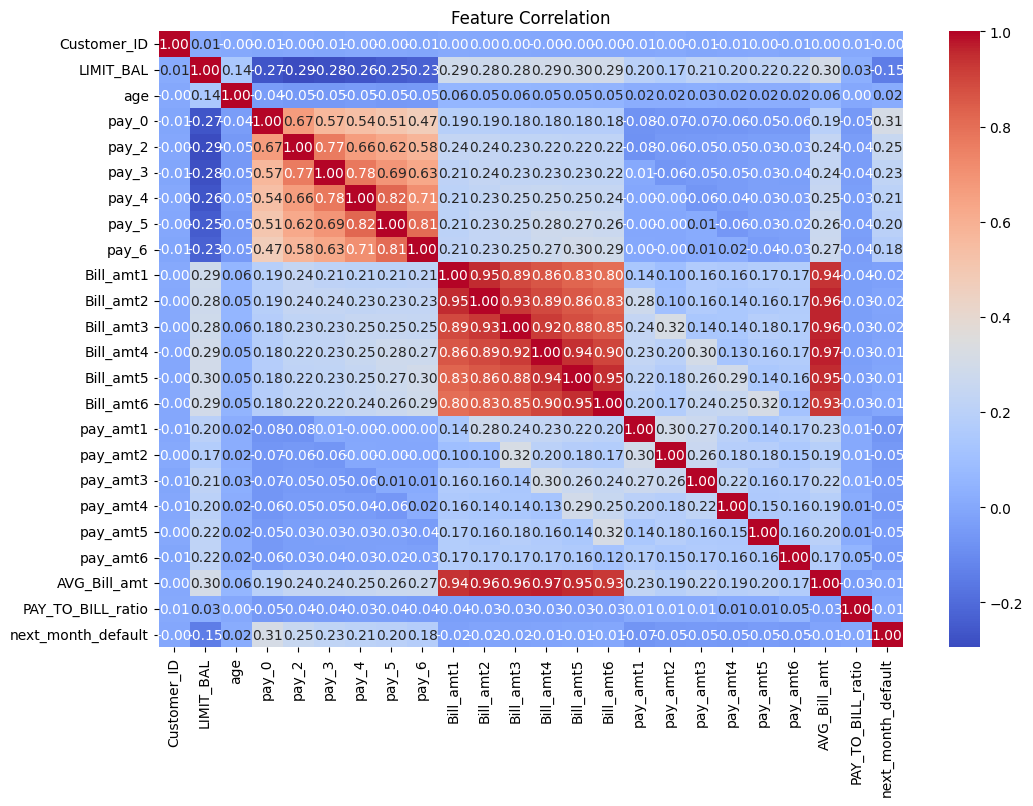

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation")


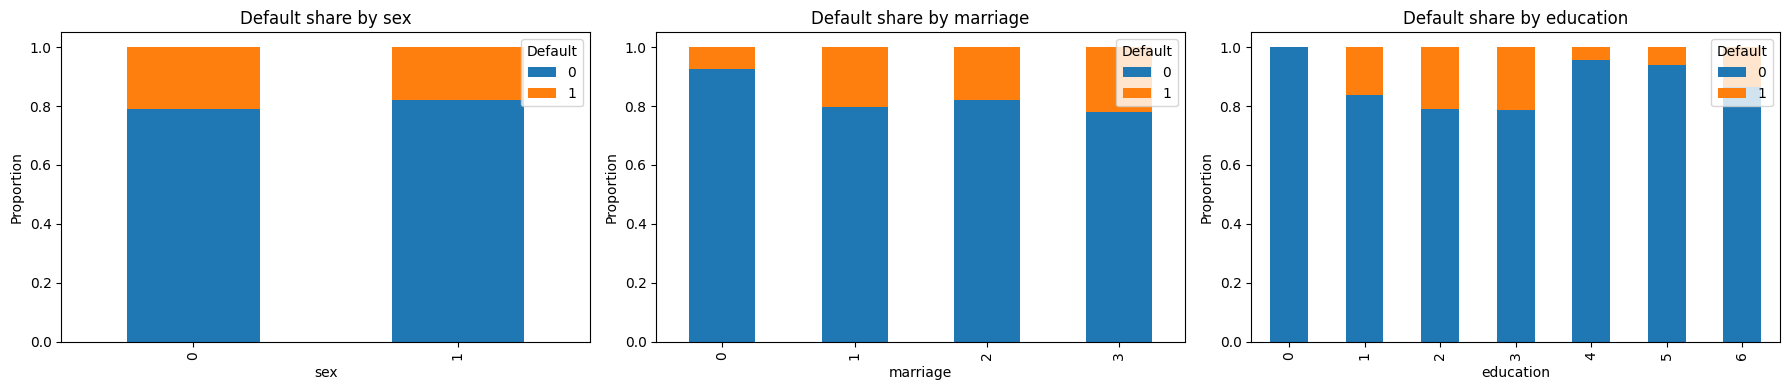

In [17]:
#  Default rate by categorical features

fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 row, 3 columns

for i, col in enumerate(['sex', 'marriage', 'education']):
    ctab = pd.crosstab(df[col], df['next_month_default'], normalize='index')
    ctab.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Default share by {col}')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Default', loc='upper right')

plt.tight_layout()
plt.show()


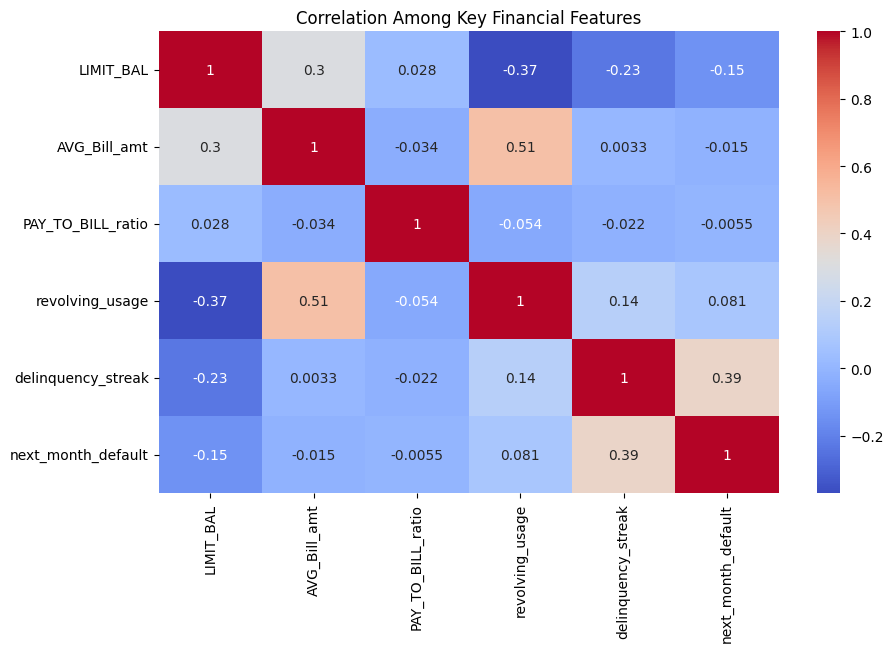

In [39]:
financial_cols = ['LIMIT_BAL', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'revolving_usage', 'delinquency_streak', 'next_month_default']
plt.figure(figsize=(10, 6))
sns.heatmap(df[financial_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Among Key Financial Features")
plt.show()


In [19]:
# Grouped averages of selected features
grouped_behavior = df.groupby('next_month_default')[['LIMIT_BAL', 'PAY_TO_BILL_ratio', 'Bill_amt1', 'pay_0']].mean()
print(grouped_behavior)
# Grouped averages of selected features
grouped_behavior = df.groupby('next_month_default')[['LIMIT_BAL', 'PAY_TO_BILL_ratio', 'Bill_amt1', 'pay_0']].mean()
print(grouped_behavior)

bill_cols = ['Bill_amt'+str(i) for i in range(1,7)]



                        LIMIT_BAL  PAY_TO_BILL_ratio     Bill_amt1     pay_0
next_month_default                                                          
0                   177539.236791           0.376491  51942.755025 -0.209687
1                   129234.449761           0.305434  47888.806963  0.666528
                        LIMIT_BAL  PAY_TO_BILL_ratio     Bill_amt1     pay_0
next_month_default                                                          
0                   177539.236791           0.376491  51942.755025 -0.209687
1                   129234.449761           0.305434  47888.806963  0.666528


In [20]:
df['delinquency_streak'] = df[['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']].apply(lambda row: sum(p >= 1 for p in row), axis=1)
# Revolving usage feature
df['revolving_usage'] = df[['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']].apply(lambda row: sum(p == 0 for p in row)/6, axis=1)

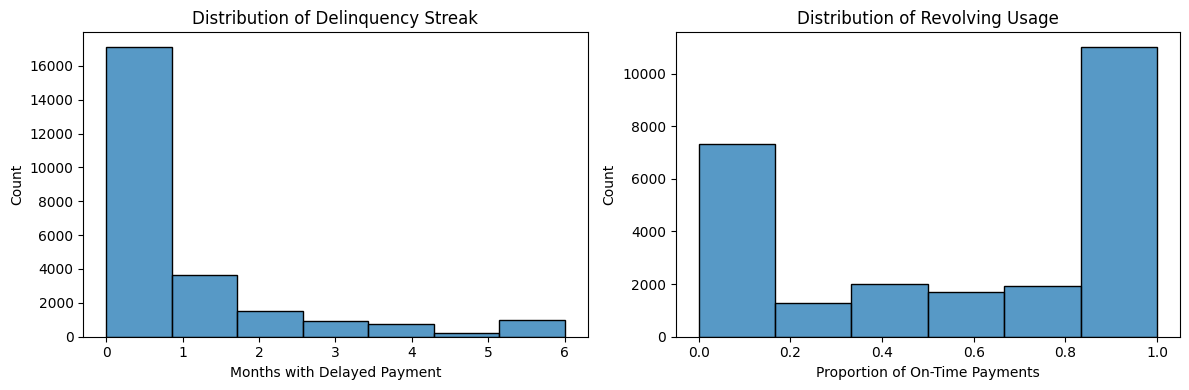

In [21]:
# Side-by-side histograms in one row
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Histogram of delinquency_streak
sns.histplot(df['delinquency_streak'], bins=7, kde=False, ax=axes[0])
axes[0].set_title('Distribution of Delinquency Streak')
axes[0].set_xlabel('Months with Delayed Payment')
axes[0].set_ylabel('Count')

# Histogram of revolving_usage
sns.histplot(df['revolving_usage'], bins=6, kde=False, ax=axes[1])
axes[1].set_title('Distribution of Revolving Usage')
axes[1].set_xlabel('Proportion of On-Time Payments')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


**Delinquency Streak**:
  - Most customers have **0 months of delayed payment**, indicating good payment behavior.
  - Distribution is **right-skewed** – very few customers have long streaks of delay.
  

**Revolving Usage**:
  - Most values are concentrated near **0**, indicating low usage or on-time payments.
  - Also **right-skewed**, with some potential outliers at high values

In [22]:
# Feature/target split
X = df.drop(columns=['Customer_ID', 'next_month_default'])
y = df['next_month_default']

# Train-Test split BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


In [23]:
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)
y_pred_lr = lr.predict(X_test)


In [24]:
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
y_pred_rf = rf.predict(X_test)


In [25]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)
y_pred_xgb = xgb.predict(X_test)

#  Predict on test set (probabilities)
y_probs = xgb.predict_proba(X_test_scaled)[:, 1]


In [26]:
from sklearn.metrics import f1_score, recall_score, fbeta_score, classification_report

def evaluate_model(y_true, y_pred, model_name):
    print(f"------ {model_name} ------")
    print("F1 Score:", f1_score(y_true, y_pred))
    print("F2 Score:", fbeta_score(y_true, y_pred, beta=2))
    print("Recall:", recall_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [27]:
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")


------ Logistic Regression ------
F1 Score: 0.006147540983606557
F2 Score: 0.0038839979285344383
Recall: 0.0031185031185031187
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      4088
           1       0.21      0.00      0.01       962

    accuracy                           0.81      5050
   macro avg       0.51      0.50      0.45      5050
weighted avg       0.70      0.81      0.72      5050

------ Random Forest ------
F1 Score: 0.23272589217919515
F2 Score: 0.37588913416727987
Recall: 0.6372141372141372
              precision    recall  f1-score   support

           0       0.53      0.10      0.16      4088
           1       0.14      0.64      0.23       962

    accuracy                           0.20      5050
   macro avg       0.34      0.37      0.20      5050
weighted avg       0.46      0.20      0.18      5050

------ XGBoost ------
F1 Score: 0.2962836685987044
F2 Score: 0.49645795246800734
Recall: 0.9033264033264

 Best Threshold = 0.11, F2 Score = 0.5815


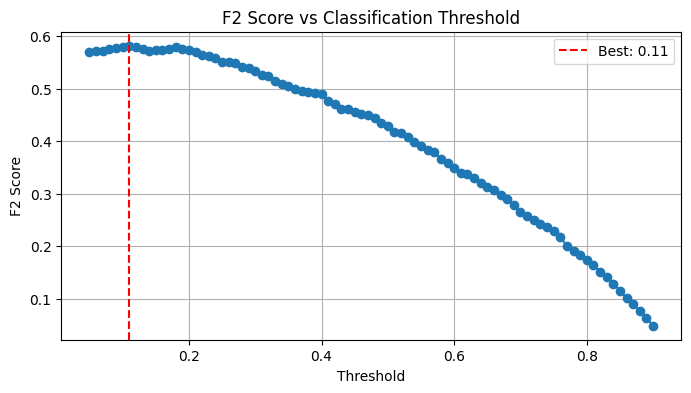

In [28]:
# F2 Threshold Optimization
thresholds = np.arange(0.05, 0.91, 0.01)
f2_scores = []

for t in thresholds:
    preds_t = (y_probs >= t).astype(int)
    f2 = fbeta_score(y_test, preds_t, beta=2)
    f2_scores.append((t, f2))

# Find best threshold
thr_df = pd.DataFrame(f2_scores, columns=['Threshold', 'F2 Score'])
best_thr = thr_df.loc[thr_df['F2 Score'].idxmax()]
print(f" Best Threshold = {best_thr['Threshold']:.2f}, F2 Score = {best_thr['F2 Score']:.4f}")

# Plot threshold vs F2 Score
plt.figure(figsize=(8, 4))
plt.plot(thr_df['Threshold'], thr_df['F2 Score'], marker='o')
plt.axvline(best_thr['Threshold'], color='red', linestyle='--', label=f"Best: {best_thr['Threshold']:.2f}")
plt.title("F2 Score vs Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel("F2 Score")
plt.legend()
plt.grid(True)
plt.show()

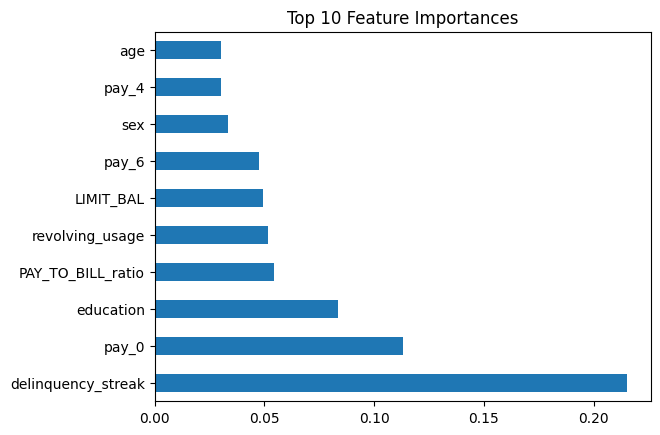

In [29]:
importances = pd.Series(xgb.feature_importances_, index=X_train_scaled.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()


In [30]:
import pandas as pd

# Replace with actual path if necessary
validation_df = pd.read_csv('/content/validate_dataset_final.csv')

In [31]:
# Assume 'df' is your training DataFrame and 'validation_df' is your test set
features = [col for col in df.columns
            if col not in ['default.payment.next.month', 'Customer_ID']
            and col in validation_df.columns]


In [32]:
print(validation_df.columns.tolist())


['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']


In [33]:
print(scaler.feature_names_in_)  # columns used during fit


['marriage' 'sex' 'education' 'LIMIT_BAL' 'age' 'pay_0' 'pay_2' 'pay_3'
 'pay_4' 'pay_5' 'pay_6' 'Bill_amt1' 'Bill_amt2' 'Bill_amt3' 'Bill_amt4'
 'Bill_amt5' 'Bill_amt6' 'pay_amt1' 'pay_amt2' 'pay_amt3' 'pay_amt4'
 'pay_amt5' 'pay_amt6' 'AVG_Bill_amt' 'PAY_TO_BILL_ratio'
 'delinquency_streak' 'revolving_usage']


In [34]:
customer_ids = validation_df['Customer_ID']
X_valid = validation_df.drop(columns=['Customer_ID'])


In [35]:
df['revolving_usage'] = df['Bill_amt1'] / df['LIMIT_BAL']
df['delinquency_streak'] = df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].apply(lambda x: sum(i > 0 for i in x), axis=1)


In [36]:
validation_df['revolving_usage'] = validation_df['Bill_amt1'] / validation_df['LIMIT_BAL']
validation_df['delinquency_streak'] = validation_df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].apply(lambda x: sum(i > 0 for i in x), axis=1)


In [37]:
from xgboost import XGBClassifier

# Train the model again (only if not already done)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_resampled, y_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [38]:
# Ensure feature list includes all columns used in training
X_valid = validation_df[scaler.feature_names_in_]
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=scaler.feature_names_in_)


In [43]:
y_valid_probs = model_xgb.predict_proba(X_valid_scaled)[:, 1]
y_pred_valid = (y_valid_probs >= best_thr['Threshold']).astype(int)

submission_df = pd.DataFrame({
    'Customer': validation_df['Customer_ID'],
    'next_month_default': y_pred_valid
})

submission_df.to_csv('submission_23117008.csv', index=False)
print("Submission saved as 'submission_23117008.csv'")


Submission saved as 'submission_23117008.csv'


In [41]:
from google.colab import files
files.download('submission_23117008.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 93%|=================== | 4690/5050 [00:12<00:00]       

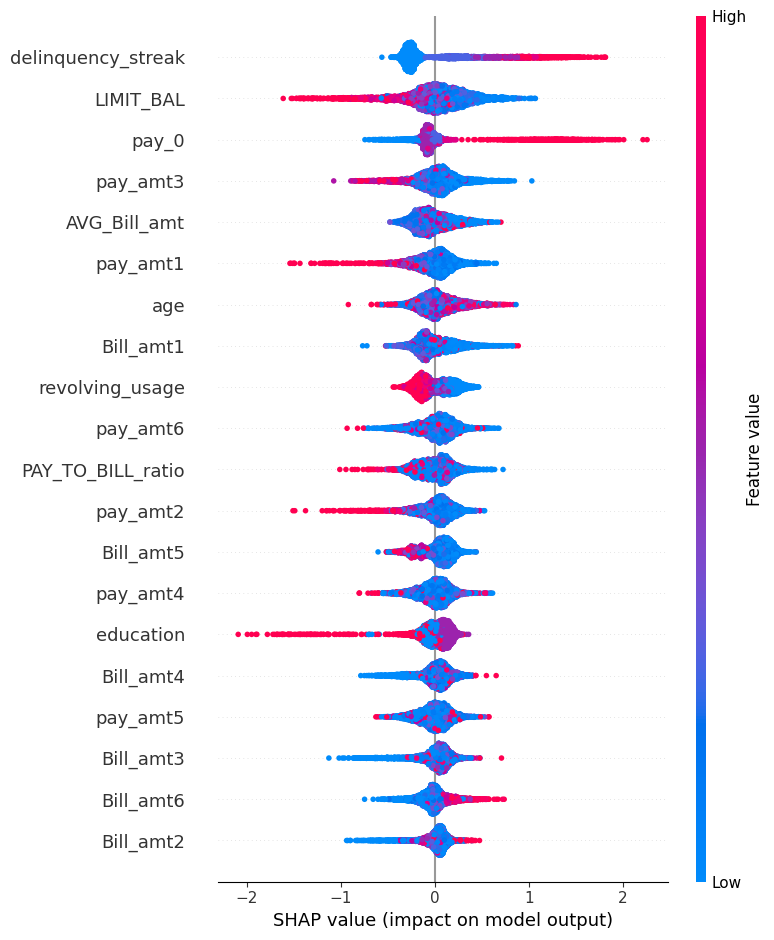

In [42]:
import shap
import matplotlib.pyplot as plt

# Make sure X_val is the test set and uses the correct columns
X_val = X_test_scaled  # if you want to explain test predictions
X_val = pd.DataFrame(X_val, columns=X_train.columns)  # ensure proper column names

# Create SHAP explainer
explainer = shap.Explainer(model_xgb, X_train_scaled)

# Compute SHAP values
shap_values = explainer(X_val)

# Plot summary
shap.summary_plot(shap_values, features=X_val)



## **SHAP Summary Plot**

This plot shows how each feature impacts the model’s decision across the validation set.

- Features like `util_ratio_1` and `pay_to_bill_1` have high influence.
- Positive SHAP values push the model towards default prediction, and negative values reduce risk.

### SHAP Additivity Note
SHAP raised a precision warning due to floating-point rounding errors between model output and SHAP values.To proceed, we safely disabled the additivity check using `check_additivity=False`. The visualizations remain valid and informative.
